In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display

# !pip install Unidecode
from unidecode import unidecode

# !pip install arabic-reshaper
# !pip install python-bidi
from bidi.algorithm import get_display
from arabic_reshaper import reshape

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

In [8]:
# خواندن داده ها

df = pd.read_csv('HotelsData.csv', encoding="utf-8")  
df.drop_duplicates(subset =None, keep = 'first', inplace = True)
df.head()

,code,kind,name,price,comment,score,province,city,star
0,ardebil-saray,hotel,هتل سارای,۴۲۰۰۰۰,(۱),۱.۸,اردبیل,اردبیل,(۳ ستاره)
1,ardebil-darya,hotel,هتل دریا,۳۰۴۰۰۰,(۸),۲.۵,اردبیل,اردبیل,(۳ ستاره)
2,ardabil-sabalan,hotel,هتل سبلان,۳۰۳۰۰۰,(۷),۳.۱,اردبیل,اردبیل,(۳ ستاره)
3,sarein-koorosh,hotel,هتل کوروش,۳۲۵۰۰۰,(۲),۲.۳,اردبیل,سرعین,(۳ ستاره)
4,saryen-ershad,hotel,هتل بوستان,۳۵۰۰۰۰,(۸),۳,اردبیل,سرعین,(۴ ستاره)


In [9]:
# درست کردن فرمت فارسی و عددی داده ها

# int columns
df['price'] = pd.to_numeric(df.price.apply(unidecode), errors='coerce').replace(np.nan, 0).astype(int)

# float column
df[['score','temp']] = df['score'].str.split('.',expand=True)
df['score'] = df['score'].replace(np.nan, '.')
df['temp'] = df['temp'].replace(np.nan, '۰').astype(float)
df['score'] = pd.to_numeric(df.score.apply(unidecode), errors='coerce').astype(float)
df['score'] = df['score'] + (df['temp'] * 0.1)

# string columns
df['star'] = df['star'].replace({'ستاره':''}, regex=True)
df[['temp1','star']] = df['star'].str.split('(',expand=True)
df['star'] = df['star'].replace({'\)': ''}, regex=True)
df['star'] = pd.to_numeric(df.star.apply(unidecode), errors='coerce').replace(np.nan, 0).astype(int)

df[['temp1','comment']] = df['comment'].str.split('(',expand=True)
df['comment'] = df['comment'].replace({'\)': ''}, regex=True)
df['comment'] = df['comment'].fillna('').astype(pd.StringDtype())
df['comment'] = pd.to_numeric(df.comment.apply(unidecode), errors='coerce').replace(np.nan, 0).astype(int)

df['code'] = df['code'].fillna('').astype(pd.StringDtype())
df['kind'] = df['kind'].fillna('').astype(pd.StringDtype())
df['name'] = df['name'].fillna('').astype(pd.StringDtype())
df['province'] = df['province'].fillna('').astype(pd.StringDtype())
df['city'] = df['city'].fillna('').astype(pd.StringDtype())

# drop temp column
df.drop('temp1', inplace=True, axis=1)
df.drop('temp', inplace=True, axis=1)

In [10]:
df.head()

,code,kind,name,price,comment,score,province,city,star
0,ardebil-saray,hotel,هتل سارای,420000,1,1.8,اردبیل,اردبیل,3
1,ardebil-darya,hotel,هتل دریا,304000,8,2.5,اردبیل,اردبیل,3
2,ardabil-sabalan,hotel,هتل سبلان,303000,7,3.1,اردبیل,اردبیل,3
3,sarein-koorosh,hotel,هتل کوروش,325000,2,2.3,اردبیل,سرعین,3
4,saryen-ershad,hotel,هتل بوستان,350000,8,3.0,اردبیل,سرعین,4


In [11]:
# پر کردن مقادیر خالی. البته چندان مهم نیست چون ستونی که داده خالی دارد بعدا حذف شده است
# Impute

In [12]:
# انجام عملیات دامی روی ستون استانها
# فقط استانهایی که تعداد سمپل آنها از 9 بزرگتر است می آید چون بعد از دامی تعداد خیلی زیاد می شود

df = df.groupby("province").filter(lambda x: len(x) >= 9)
df_temp = pd.get_dummies(df, columns=["province"])

df_temp

,code,kind,name,price,comment,score,city,star,province_آذربایجان شرقی,province_اردبیل,...,province_تهران,province_خراسان رضوی,province_فارس,province_قزوین,province_مازندران,province_هرمزگان,province_کردستان,province_گلستان,province_گیلان,province_یزد
0,ardebil-saray,hotel,هتل سارای,420000,1,1.8,اردبیل,3,0,1,...,0,0,0,0,0,0,0,0,0,0
1,ardebil-darya,hotel,هتل دریا,304000,8,2.5,اردبیل,3,0,1,...,0,0,0,0,0,0,0,0,0,0
2,ardabil-sabalan,hotel,هتل سبلان,303000,7,3.1,اردبیل,3,0,1,...,0,0,0,0,0,0,0,0,0,0
3,sarein-koorosh,hotel,هتل کوروش,325000,2,2.3,سرعین,3,0,1,...,0,0,0,0,0,0,0,0,0,0
4,saryen-ershad,hotel,هتل بوستان,350000,8,3.0,سرعین,4,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,yazd-moshirolmamalek,hotel,هتل باغ مشیر الممالک,650000,15,4.2,یزد,4,0,0,...,0,0,0,0,0,0,0,0,0,1
396,firoozeh-yazd,hotel,هتل فیروزه,220000,40,4.7,یزد,3,0,0,...,0,0,0,0,0,0,0,0,0,1
397,yazd-laleh,hotel,هتل لاله,440000,4,4.0,یزد,3,0,0,...,0,0,0,0,0,0,0,0,0,1
398,yazd-labekhandagh,hotel,هتل تاریخی لب خندق,557000,2,3.8,یزد,3,0,0,...,0,0,0,0,0,0,0,0,0,1


In [13]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 317 entries, 0 to 399
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   code                     317 non-null    string 
 1   kind                     317 non-null    string 
 2   name                     317 non-null    string 
 3   price                    317 non-null    int32  
 4   comment                  317 non-null    int32  
 5   score                    286 non-null    float64
 6   city                     317 non-null    string 
 7   star                     317 non-null    int32  
 8   province_آذربایجان شرقی  317 non-null    uint8  
 9   province_اردبیل          317 non-null    uint8  
 10  province_اصفهان          317 non-null    uint8  
 11  province_تهران           317 non-null    uint8  
 12  province_خراسان رضوی     317 non-null    uint8  
 13  province_فارس            317 non-null    uint8  
 14  province_قزوین           3

In [8]:
df_temp.drop(columns = ['code','kind','name','comment','city'], inplace=True, axis=1)
df_temp.drop('score', inplace=True, axis=1)


df_model = df_temp
df_model = df_model.sample(frac=1,random_state = 10).reset_index(drop=True)

In [9]:
# df_model = df_model[df_model['star'] >= 3]
df_model.head()

,price,star,province_آذربایجان شرقی,province_آذربایجان غربی,province_اردبیل,province_اصفهان,province_البرز,province_ایلام,province_بوشهر,province_تهران,...,province_مرکزی,province_هرمزگان,province_همدان,province_کردستان,province_کرمان,province_کرمانشاه,province_کهگیلویه و بویراحمد,province_گلستان,province_گیلان,province_یزد
0,585000,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,425000,4,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,525000,4,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,447000,4,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,405000,5,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [10]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


# df = pd.DataFrame({"WEIGHT": [15, 18, 12,10],
#                    "PRICE": [1,3,2,5]},
#                    index = ["Orange","Apple","Banana","Grape"])
# scaler = MinMaxScaler()
# df1 = pd.DataFrame(scaler.fit_transform(df),
#                    columns=['WEIGHT','PRICE'],
#                    index = ['Orange','Apple','Banana','Grape'])

scaler = MinMaxScaler()
df_model = pd.DataFrame(scaler.fit_transform(df_model),
                   columns=df_model.columns,
                   index = df_model.index)
df_model.head()

,price,star,province_آذربایجان شرقی,province_آذربایجان غربی,province_اردبیل,province_اصفهان,province_البرز,province_ایلام,province_بوشهر,province_تهران,...,province_مرکزی,province_هرمزگان,province_همدان,province_کردستان,province_کرمان,province_کرمانشاه,province_کهگیلویه و بویراحمد,province_گلستان,province_گیلان,province_یزد
0,0.211957,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.153986,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.190217,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.161957,0.75,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.146739,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
temp_data = df_model.to_numpy()
X = temp_data[:,1:]
y = temp_data[:,0]

In [12]:
X.shape

(356, 26)

In [13]:
y.shape

(356,)

In [14]:
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

In [15]:
for degree in [1,2,3,4,5,6]:
    model = PolynomialRegression(degree).fit(X, y)
#     .predict(X_test)
    print(degree,model.score(X,y))


1 0.42292001666386037
2 0.5524840000068449
3 0.6186356222184723
4 0.6545060742890911
5 0.5902871366267475
6 0.6194272339637646


C:\Users\a.alimadadi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass param_name=polynomialfeatures__degree, param_range=[1, 2, 3, 4, 5, 6, 7] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\a.alimadadi\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\a.alimadadi\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\a.alimadadi\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\a.alimadadi\Anaconda3\lib\site-packages\sklearn\linear_mode

C:\Users\a.alimadadi\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\a.alimadadi\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\a.alimadadi\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\a.alimadadi\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py", line 512, in fit
    X, y, X_offset, y_offset, X_scale = self._preprocess_data(
  File "C:\Users\a.alimadadi\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py", line 128, in _preprocess_data
    X = check_array(X, copy=copy, accept_sparse=['csr', 'csc'],
  File "C:\Users\a.alimadadi\Anaconda3\lib\site-packages\

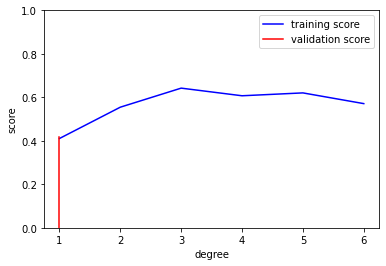

In [16]:
from sklearn.model_selection import validation_curve
degree = [1,2,3,4,5,6,7]

train_score, val_score = validation_curve(PolynomialRegression(), X, y,
                                          'polynomialfeatures__degree', degree, cv=7)

plt.plot(degree, np.median(train_score, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

In [17]:
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score
# # split the data with 50% in each set
# X1, X2, y1, y2 = train_test_split(X, y, random_state=10,train_size=0.5)

# for degree in [1]:
#     model = PolynomialRegression(degree).fit(X1, y1)

    
#     yfit = model.predict(X2)
#     print(degree,model.score(X2,y2))
   

# plt.scatter(X2, y2)
# plt.plot(X2.ravel(), yfit);


In [18]:
from sklearn.model_selection import GridSearchCV

param_grid = {'polynomialfeatures__degree': np.arange(7),
              'linearregression__fit_intercept': [True, False],
              'linearregression__normalize': [True, False]}

grid = GridSearchCV(PolynomialRegression(), param_grid, cv=7)

grid.fit(X, y);

grid.best_params_

C:\Users\a.alimadadi\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\a.alimadadi\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\a.alimadadi\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\a.alimadadi\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 292, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\a.alimadadi\Anaconda3\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\a.alimadadi\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_t

C:\Users\a.alimadadi\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\a.alimadadi\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\a.alimadadi\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\a.alimadadi\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 292, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\a.alimadadi\Anaconda3\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\a.alimadadi\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_t

C:\Users\a.alimadadi\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\a.alimadadi\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\a.alimadadi\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\a.alimadadi\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 292, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\a.alimadadi\Anaconda3\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\a.alimadadi\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_t

C:\Users\a.alimadadi\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\a.alimadadi\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\a.alimadadi\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\a.alimadadi\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 292, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\a.alimadadi\Anaconda3\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\a.alimadadi\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_t

{'linearregression__fit_intercept': False,
 'linearregression__normalize': True,
 'polynomialfeatures__degree': 1}